In [1]:
using Pkg, PerlaTonettiWaugh, Plots, Interpolations
pkg"activate ."

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [2]:
# Define common objects. 
params = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (global_transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

898

In [3]:
d_0 = params.d_0
d_T = params.d_T
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [4]:
# use E_nodes of length 50
L = 50
old_x0 = settings.global_transition_x0
old_x0_interpolated = LinearInterpolation(range(0, stop = 1, length = length(old_x0)), old_x0)
new_x0 = old_x0_interpolated.(range(0, stop = 1, length = L-1))

settings = merge(settings, (global_transition_x0 = new_x0, 
                            global_transition_lb = (new_x0 .- 1e-2),
                            global_transition_ub = (new_x0 .+ 1e-2),
                            E_node_count = L,
                            entry_residuals_nodes_count = L,
                            global_transition_weights = [fill(15, 3); fill(1, L-3)]));

## Welfare in steady states

### Steady state at `T`

In [5]:
display_stationary_sol(stationary_sol);

g = 0.020615710253102364
z_hat = 1.4039337090190345
Ω = 1.2562899003237646
y = 1.3124933028572352
c = 1.3124933028572352
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.020615710253102364, 0.02, 1.0, 1.3124933028572352)
λ_ii = 0.7552342507090134
L_tilde = 0.2099540490178484
z_bar = 1.661287297562375
w = 0.41640447602826725
x = 1.0
π_min = 0.057942557180211345
r = 0.09361571025310236
a = 9.160936798927867
b = 0.1424454938003916
S = 0.03389742154659973


### Steady state at `0`

In [6]:
display_stationary_sol(stationary_sol_0);

g = 0.010930652403331097
z_hat = 1.813536131626652
Ω = 1.7797899977898557
y = 1.4215794009183362
c = 1.4215794009183362
U_bar = getfield(PerlaTonettiWaugh, Symbol("##21#22")){Float64,Float64,Float64,Float64}(0.010930652403331097, 0.02, 1.0, 1.4215794009183362)
λ_ii = 0.8982453618545706
L_tilde = 0.19292029410354766
z_bar = 1.7613866270362195
w = 0.44149454256973625
x = 1.0
π_min = 0.04969310649379504
r = 0.0839306524033311
a = 12.468098351241073
b = 0.1490608571684243
S = -0.011680460694423862


# Transition dynamics

Setup for optimizer:

In [7]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0));

Find the corresponding solution:

In [20]:
# result = solve_full_model_global(settings);
using BenchmarkTools
result = @time solve_full_model_nlopt(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

163.069829 seconds (309.51 M allocations: 391.770 GiB, 22.58% gc time)


In [9]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


49-element Array{Float64,1}:
 -0.9283233397558605  
 -0.8917065208748177  
 -0.8550897019937749  
 -0.818472883112732   
 -0.7774405159624747  
 -0.7264731652064844  
 -0.6755058144504943  
 -0.6245384636945042  
 -0.5862304378855367  
 -0.5558344901684585  
 -0.5254385424513803  
 -0.49504259473430223 
 -0.45348716095675523 
  ⋮                   
 -0.05704910208956028 
 -0.05375200999942609 
 -0.05045491790929188 
 -0.04715782581915767 
 -0.04362731431259914 
 -0.03972333173976165 
 -0.035819349166924155
 -0.03191536659408668 
 -0.030599026456878377
 -0.03043274962439417 
 -0.03026647279190996 
 -0.03010019595942575 

## Plots for Ω and `entry_residuals`

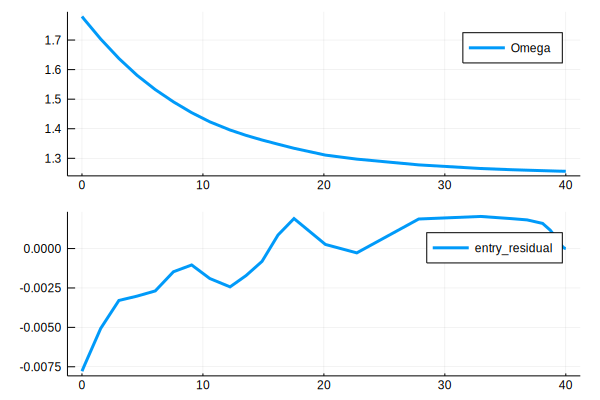

In [10]:
solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

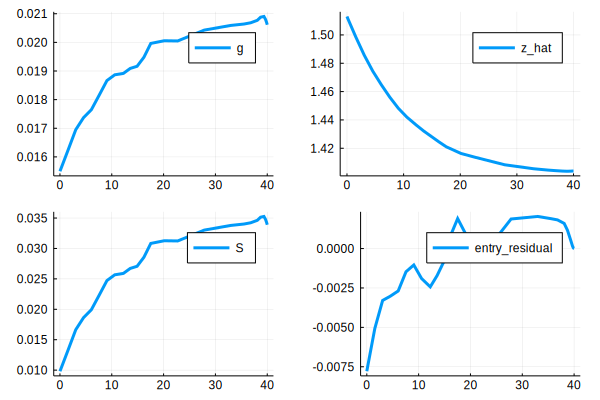

In [11]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

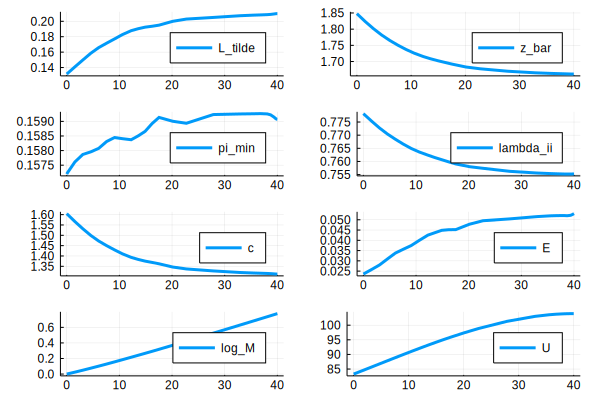

In [12]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

# Welfare analysis

### `log_M(t)`

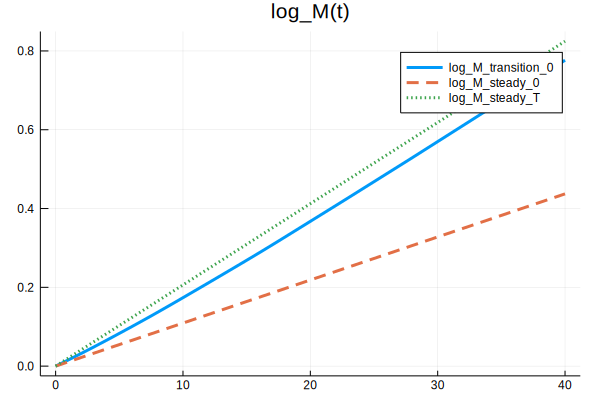

In [13]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

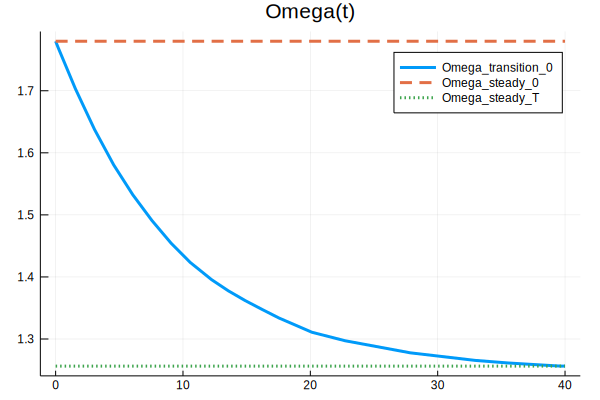

In [14]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

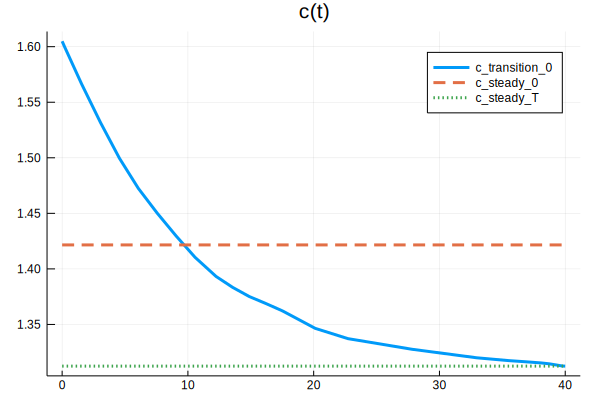

In [15]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

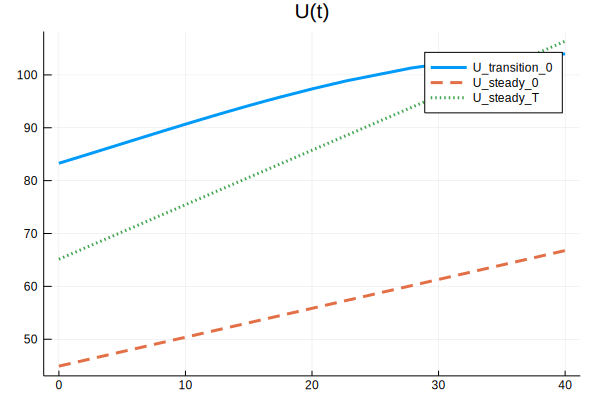

In [16]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [17]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), params)

2.1035217190836835

### `M(0)` by autarky and transition from `t=0`

In [18]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), params)

1.391288096095522